In [ ]:
import cv2
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/shopcom

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/shopcom


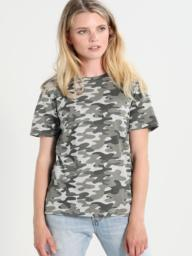

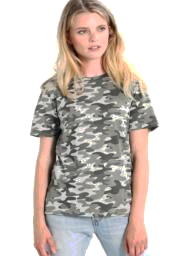

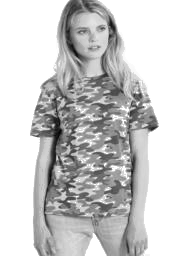

(224, 224)


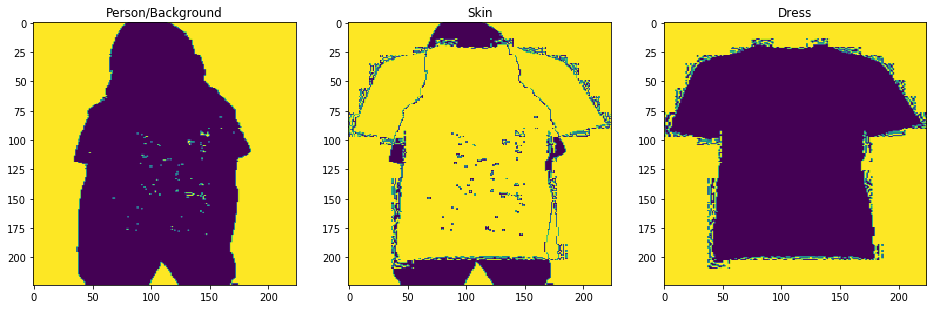

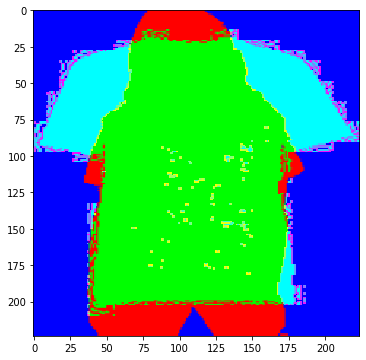

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import imutils
import pickle
import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, Activation, ReLU, Input, Dropout, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
import os



img = cv2.imread('000004_0.jpg')
from google.colab.patches import cv2_imshow
# Displaying the image 
cv2_imshow( img)
#scaling 
#original=cv2.resize(img,(768,1066))
#cv2_imshow(original)
body=img
#body=original
body[body>=220]=255
cv2_imshow(body)
body=cv2.cvtColor(body, cv2.COLOR_BGR2GRAY)
cv2_imshow(body)


### ENCODE BODY ###
body[body == 255] = 0
body[body > 0] = 255
body = cv2.resize(body,(224,224))

dress = cv2.imread('000004_1.jpg',0)
### ENCODE DRESS ###
dress[dress == 255] = 0
dress[dress > 0] = 255
dress = cv2.resize(dress,(224,224))
print(dress.shape)

### ENCODE SKIN ###
skin = body - dress


plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title('Person/Background')
bg = (255 - body)/255
plt.imshow(bg)
plt.subplot(1,3,2)
plt.title('Skin')
skin = (255 - skin)/255
plt.imshow(skin)
plt.subplot(1,3,3)
plt.title('Dress')
dress = (255 - dress)/255
plt.imshow(dress)



### COMBINE BACKGROUND, SKIN, DRESS ###
gt = np.zeros((224,224,3))
gt[:,:,0] = (1-skin)
gt[:,:,1] = (1-dress)
gt[:,:,2] = bg

plt.figure(figsize=(6,6))
plt.imshow(gt)

In [ ]:
### ENCODE BACKGROUND, SKIN, DRESS FOR ALL TRAIN IMAGES ###

images_original = []
images_gt = []

mean = np.zeros((224,224,3))
n_img = 3000

ximage=os.listdir('ShopcomHackathonDataset/train/image')
ximage.sort()

xcloth=os.listdir('ShopcomHackathonDataset/train/cloth')
xcloth.sort()

for i in tqdm.tqdm(range(0,n_img)):
    
    original = cv2.imread('ShopcomHackathonDataset/train/image/'+ximage[i])
    #cv2_imshow(original)
    original = cv2.resize(original,(224,224))
    images_original.append(original)
    mean[:,:,0]=mean[:,:,0]+original[:,:,0]
    mean[:,:,1]=mean[:,:,1]+original[:,:,1]
    mean[:,:,2]=mean[:,:,2]+original[:,:,2]

    body=original
    body[body>220]=255
    body=cv2.cvtColor(body, cv2.COLOR_BGR2GRAY)
    

    #body=cv2.imread('ShopcomHackathonDataset/train/image/'+ximage[i],0)
    #body[body>=220]=255
    #body = cv.imread('./data/body/body'+str(i)+'.jpg',0)

    dress = cv2.imread('ShopcomHackathonDataset/train/cloth/'+xcloth[i],0)
    
    dress[dress == 255] = 0
    dress[dress > 0] = 255
    dress = cv2.resize(dress,(224,224))

    body[body == 255] = 0
    body[body > 0] = 255
    body = cv2.resize(body,(224,224))

    skin = body - dress
    bg = (255 - body)/255
    skin = (255 - skin)/255
    dress = (255 - dress)/255
    
    gt = np.zeros((224,224,3))
    gt[:,:,0] = (1-skin)
    gt[:,:,1] = (1-dress)
    gt[:,:,2] = bg
   
    images_gt.append(gt)

mean = mean / n_img
mean = mean.astype('int')

100%|██████████| 3000/3000 [34:03<00:00,  1.62it/s]


In [ ]:
pickle.dump(mean, open("./mean81.pkl", "wb"))

In [ ]:

def custom_activation(x):
    return K.relu(x, alpha=0.0, max_value=1)


def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

smooth = 1.


In [ ]:
def get_unet(do=0, activation=ReLU):
  
    inputs = Input((None, None, 3))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(inputs)))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(pool1)))
    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(pool2)))
    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(pool3)))
    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(pool4)))
    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(up6)))
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(up7)))
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(up8)))
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(up9)))
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv9)))

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics=['accuracy'])

    return model

In [ ]:
x_raw = np.asarray(images_original) - mean.reshape(-1,224,224,3) 
x_gt = np.asarray(images_gt).reshape(-1,224,224,3)

In [ ]:
model = get_unet()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, None, None, 3 0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout) 

In [ ]:
history = model.fit(x_raw, x_gt, epochs=50)   


Train on 3000 samples
Epoch 1/50
3000/3000 [==============================] - 35s 12ms/sample - loss: 0.4216 - acc: 0.7292
Epoch 2/50
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.2388 - acc: 0.8076
Epoch 3/50
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.2154 - acc: 0.8171
Epoch 4/50
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.2053 - acc: 0.8214
Epoch 5/50
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.1956 - acc: 0.8257
Epoch 6/50
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.1893 - acc: 0.8284
Epoch 7/50
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.1857 - acc: 0.8301
Epoch 8/50
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.1786 - acc: 0.8329
Epoch 9/50
3000/3000 [==============================] - 25s 8ms/sample - loss: 0.1877 - acc: 0.8298
Epoch 10/50
3000/3000 [==============================] - 25s 8ms/sample - los

In [ ]:
model.save('./fashion_unet.h5')